In [1]:
import json
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt

mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 40})

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Analyzing Rent Prices vs. Taxi Trips

In [2]:
# taxi id - zillow id mapping
tz_map = json.load(open('./taxi_zillow_mapping.json'))

# Group zillow and taxi data according to composite ID.
taxi_to_cluster = {}
zillow_to_cluster = {}
cid_to_cluster = {}
for cluster in tz_map:
    cid_to_cluster[cluster['id']] = cluster
    for t in cluster['taxi_ids']:
        assert t not in taxi_to_cluster
        taxi_to_cluster[t] = cluster['id']
    for z in cluster['zillow_ids']:
        assert z not in zillow_to_cluster
        zillow_to_cluster[z] = cluster['id']
        
tz_map[4:6]

[{u'id': 5,
  u'name': u'Prospect Park',
  u'taxi_ids': [190],
  u'zillow_ids': [403161]},
 {u'id': 6,
  u'name': u'Brownsville',
  u'taxi_ids': [35],
  u'zillow_ids': [193526]}]

In [3]:
from datetime import date

In [53]:
def get_taxis(weekend_only=None,
              day_normalized=True,
              add_green=True,
              event='DO',
              plot_settings={},
              min_trips=0,
              max_trips=1e100,
              min_year=2013,
              min_month=1,
              plot=False,
              metric='count'):
    # Load the yellow taxi analysis
    yellow = pd.read_csv('yellow_daily.csv', index_col=None, header=None)
    green = pd.read_csv('green_daily.csv', index_col=None, header=None)
    yellow.columns = ['location_id', 'event', 'year', 'month', 'day',
                     'passengers', 'distance', 'fare', 'count']
    green.columns = yellow.columns[:]
    
    if add_green:
        combined = pd.concat([yellow, green], axis=0, ignore_index=True)
        combined = combined.groupby(['location_id', 'event', 'year', 'month', 'day'])\
            .sum().reset_index()
        yellow = combined

    is_weekend = []
    SATURDAY = 5
    for y in yellow.itertuples():
        d = date(y.year, y.month, y.day)
        is_weekend.append(d.weekday() >= SATURDAY)
        
    if weekend_only == True:
        yellow = yellow[is_weekend]
    elif weekend_only == False:
        yellow = yellow[[not w for w in is_weekend]]

    # What are daily stats for the entire city?
    yellow_citywide = yellow.drop(['location_id'], axis=1)\
        .groupby(by=['event', 'year', 'month', 'day'])\
        .sum().reset_index()
    yellow_citywide = yellow_citywide[yellow_citywide['year'] >= 2013]
    cw = yellow_citywide
    cw = cw[cw['event'] == event]
    cw = cw[cw['year'] < 2017]
    cw = cw[cw['year'] >= min_year]
    cw = cw[['year', 'month', 'day', metric]]
    cw_mean = cw[metric].mean()
    #print(len(cw))

    yellow['composite_id'] = yellow['location_id'].map(lambda x: taxi_to_cluster.get(x, -1))
    
    yellow_composite = yellow.drop('location_id', axis=1)\
        .groupby(by=['composite_id', 'event', 'year', 'month', 'day'])\
        .sum().reset_index()
        
    available_cluster_ids = list(yellow['composite_id'].unique())
    by_cluster_map = {}
    counts = []
    for cluster_id in available_cluster_ids:
        # Get taxi dropoffs
        yc = yellow_composite
        taxis = yc[yc['composite_id'] == cluster_id]
        taxis = taxis[taxis['event'] == event]
        taxis = taxis[taxis['year'] < 2017]
        taxis = taxis[taxis['year'] >= min_year]
        taxis = taxis[(taxis['year'] > min_year) | (taxis['month'] >= min_month)]
        taxis = taxis[['year', 'month', 'day', metric]]
        sum_count = taxis[metric].sum()
        counts.append(sum_count)
        tlen = len(taxis)
        taxis = pd.merge(taxis, cw, on=['year', 'month', 'day'])
        assert len(taxis) == tlen
        
        if day_normalized:
            cy = taxis[metric + '_y']
            taxis[metric] = taxis[metric + '_x'].as_matrix() * cw_mean / cy.as_matrix()
        else:
            taxis[metric] = taxis[metric + '_x']
        taxis = taxis[['year', 'month', 'day', metric]]
            
        taxis = taxis[['year', 'month', metric]]
        taxis = taxis.groupby(by=['year', 'month']).mean().reset_index()
        
        if sum_count < min_trips or sum_count > max_trips:
            continue

        by_cluster_map[cluster_id] = taxis
    
    if plot:
        plt.figure()
        plt.hist(np.log10(np.array(counts)), **plot_settings)
        plt.ylabel('log(trips)')
        plt.show()
        
    return yellow_composite, by_cluster_map

Download the files `yellow_daily.csv` and `green_daily.csv` from the [S3 bucket](https://console.aws.amazon.com/s3/buckets/cipta-bigdata1004/?region=us-west-2&tab=overview)

# Adjust Zillow Rent Prices With Inflation

In [30]:
def get_zillow(fname='./Neighborhood_MedianRentalPrice_1Bedroom.csv',
              adjust_inflation=True):
    # Load zillow rent prices
    # DL from: http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_1Bedroom.csv
    zillow = pd.read_csv(fname)
    z = zillow
    zillow = zillow[(z['City'] == 'New York') & (z['State'] == 'NY')]
    early_cols = ['{}-{:02}'.format(year, month) for year in [2010, 2011, 2012, 2017] for month in range(1,13)]
    early_cols = [c for c in early_cols if c in zillow.columns]
    zillow = zillow.drop(early_cols, axis=1)

    # Read inflation data
    inflation = pd.read_csv('cpi_inflation.csv', index_col='Year')
    
    # Create an array with zillow prices adjusted by inflation.
    zillow_inf_adjust = zillow.copy()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    standard = inflation.ix[2016]['Dec'] # Rescale values to this time.
    for year in range(2013, 2017):
        for month in range(1, 13):
            colname = '{}-{:02}'.format(year, month)
            col = zillow_inf_adjust[colname]
            col = standard / inflation.ix[year][months[month - 1]] * col
            zillow_inf_adjust[colname] = col
            
    if not adjust_inflation:
        zillow_inf_adjust = zillow # Revert
    
    # What is the Zillow Neighborhood ID?
    zillow_shape = json.load(open('ZillowNeighborhoods-NY.geojson'))
    # Need a mapping from zillow region name to zillow ID
    z_name_to_id = {}
    for z in zillow_shape['features']:
        prop = z['properties']
        zid = int(prop['RegionID'])
        z_name_to_id[prop['Name']] = prop['RegionID']

    region_ids = []
    for z in zillow_inf_adjust.itertuples():
        regid = z_name_to_id[z.RegionName]
        region_ids.append(regid)
#        print(z.RegionName, regid)
    zillow_inf_adjust['RegionId'] = region_ids
        
    zillow_inf_adjust['CompositeId'] =\
        zillow_inf_adjust['RegionId'].map(lambda x: zillow_to_cluster.get(int(x), -1))
        
    z = zillow_inf_adjust
    zillow_composite = z.drop([
            'RegionName', 'City',
            'State', 'Metro', 'CountyName',
            'SizeRank', 'RegionId'], axis=1)\
        .groupby(by=['CompositeId'])\
        .mean().reset_index()
        
    zillow_t = zillow_composite.set_index('CompositeId').T
    by_cluster = {}
    for cluster_id in list(zillow_t.columns):
        col = zillow_t[cluster_id]
        pairs = zip(col.index, col)
        rows = []
        for date, price in pairs:
            year = int(date[:4])
            month = int(date[-2:])
            rows.append((year, month, price))
        df = pd.DataFrame(rows, columns=['year', 'month', 'price'])
        by_cluster[cluster_id] = df
        
    return zillow_composite, by_cluster

# Generate Plots

In [36]:
def single_location(name,
                    zillow_composite,
                    combined,
                    line_title,
                    taxi_line_title,
                    scatter_title):
    # find cluster matching that name.
    cluster = None
    for c in tz_map:
        if name.lower() in c['name'].lower():
            cluster = c
            break
    print(cluster)
    name = cluster['name']

    cid = cluster['id']
    # Get taxi data
    taxi = combined[1][cid]
    zillow = zillow_composite[1][cid]
    join = pd.merge(taxi, zillow, on=['year', 'month'])
    join = join.set_index(['year', 'month'])
    # Get one of the areas' columns

    if line_title is not None:
        plt.figure()
        ax = join['price'].plot(ax=plt.gca(), title=line_title, legend=False)
        plt.ylabel('Rent ($)')
        #ax = taxis.plot(ax=plt.gca(), legend=False)
        plt.show()

    if taxi_line_title is not None:
        plt.figure()
        ax = join['count'].plot(ax=plt.gca(), title=taxi_line_title, legend=False)
        plt.ylabel('Trips')
        #ax = taxis.plot(ax=plt.gca(), legend=False)
        plt.show()

    if scatter_title is not None:
        plt.figure()
        plt.scatter(join['count'], join['price'])
        plt.title(scatter_title)
        plt.show()
        print(join['count'].corr(join['price']))

    return join

In [35]:
yellow = get_taxis(add_green=False)
combined = get_taxis(add_green=True)
yellow_no_norm = get_taxis(add_green=False, day_normalized=False)
yellow_pu = get_taxis(add_green=False, event='PU')
combined_pu = get_taxis(event='PU')

1461
1461
1461
1461
1461


In [11]:
zillow_composite = get_zillow()

In [12]:
# What neighborhoods are available?
avail_ids = set(zillow_composite[1].keys()).intersection(set(yellow[1].keys()))
for c in tz_map:
    if c['id'] in avail_ids:
        print(c['name'])

Central Park
Greenpoint
Bayside-Douglaston-Oakland Gardens
East Elmhurst-Jackson Heights
Park Slope
Long Island City/Hunters Point
Kew Gardens
Cobble Hill
East Village
East Flatbush
TriBeCa/Civic Center
Brooklyn Heights
Kingsbridge Heights-University Heights/Morris Heights
East Harlem
Elmhurst
Fort Greene
Norwood
Windsor Terrace
Woodside
Forest Hills-Forest Park/Highland Park-Glendale
Rego Park
Flushing-Murray Hill-Auburndale
Bay Ridge
Clinton Hill-Bedford Stuyvesant-Crown Heights
Concourse
Midwood
Kew Gardens Hills
Prospect Heights
Battery Park City
Boerum Hill-Carroll Gardens-Gowanus
Hamilton Heights-Manhattanville
Pelham Bay-Schuylerville/Edgewater Park
East New York
Kensington
Mount Hope
Inwood
Chinatown-Lower East Side
Harlem
Parkchester
Pelham Parkway
Briarwood/Jamaica Hills
Washington Heights
Astoria Heights-Astoria
Carnegie Hill-Upper East Side
Midtown
Sunnyside
Bushwick
Brighton Beach
Little Italy/NoLiTa
Jamaica
Erasmus-Flatbush/Ditmas Park
Upper West Side
Sunset Park-Greenwoo

{u'zillow_ids': [199001], u'id': 145, u'name': u'Williamsburg', u'taxi_ids': [80, 217, 255, 256]}


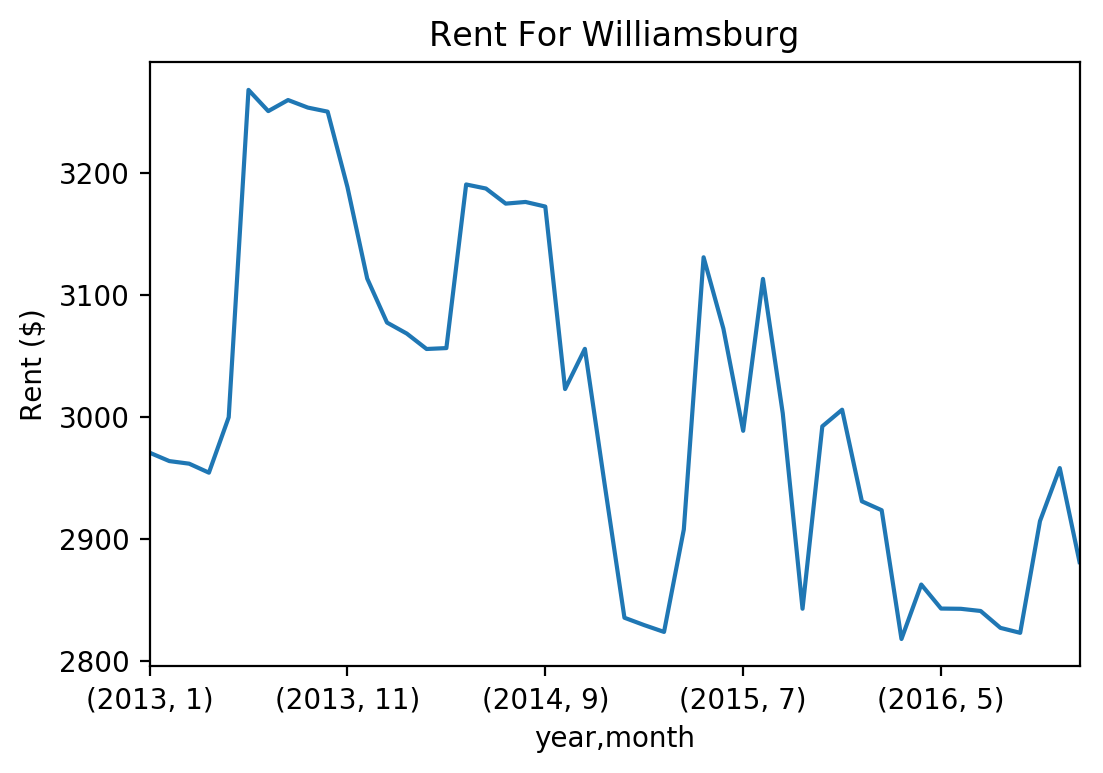

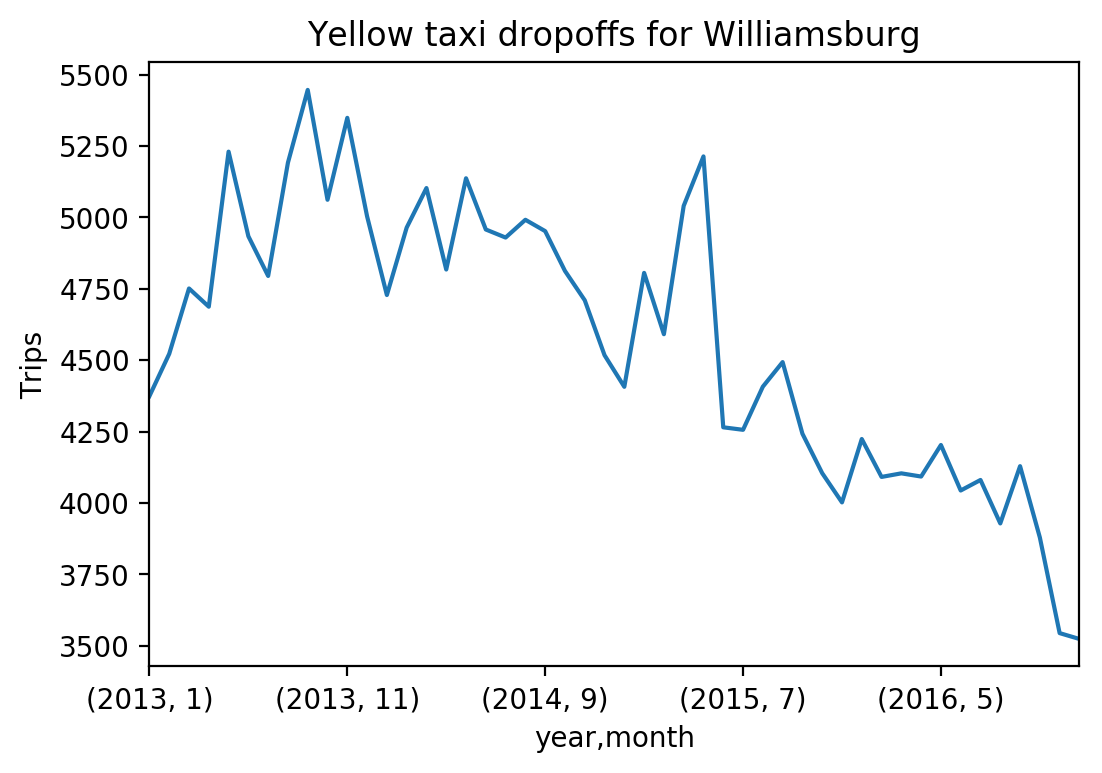

In [38]:
_ = single_location('Williamsburg', zillow_composite, yellow,
                'Rent For Williamsburg',
                'Yellow taxi dropoffs for Williamsburg',
                None)

{u'zillow_ids': [199001], u'id': 145, u'name': u'Williamsburg', u'taxi_ids': [80, 217, 255, 256]}


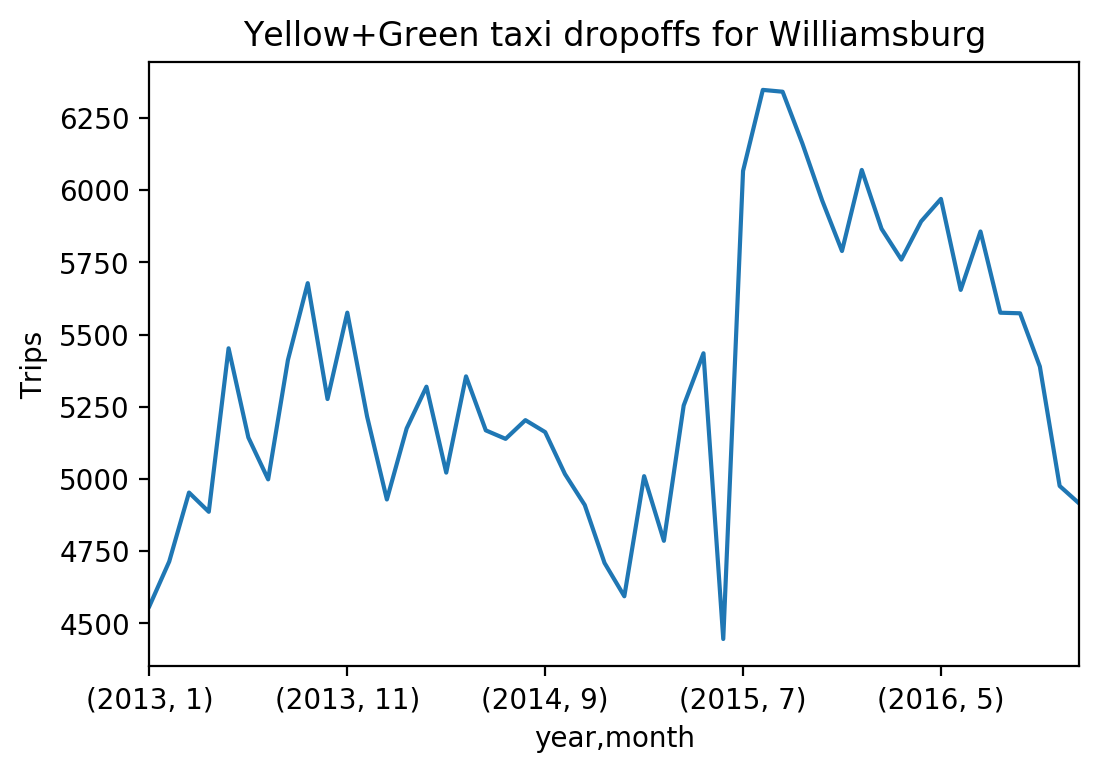

In [40]:
_ = single_location('Williamsburg', zillow_composite, combined,
                None,
                'Yellow+Green taxi dropoffs for Williamsburg',
                None)

{u'zillow_ids': [199001], u'id': 145, u'name': u'Williamsburg', u'taxi_ids': [80, 217, 255, 256]}


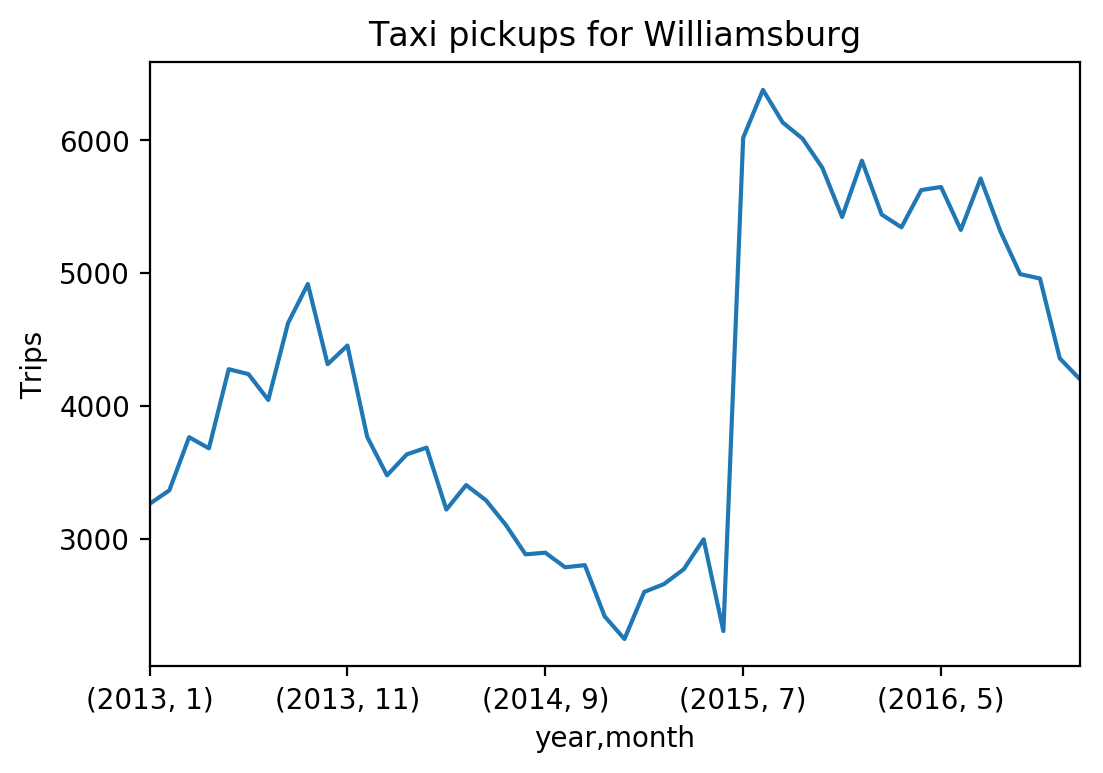

In [42]:
_ = single_location('Williamsburg', zillow_composite, combined_pu,
                None,
                'Taxi pickups for Williamsburg',
                None)

{u'zillow_ids': [276254], u'id': 135, u'name': u'Chelsea', u'taxi_ids': [68, 90, 246]}


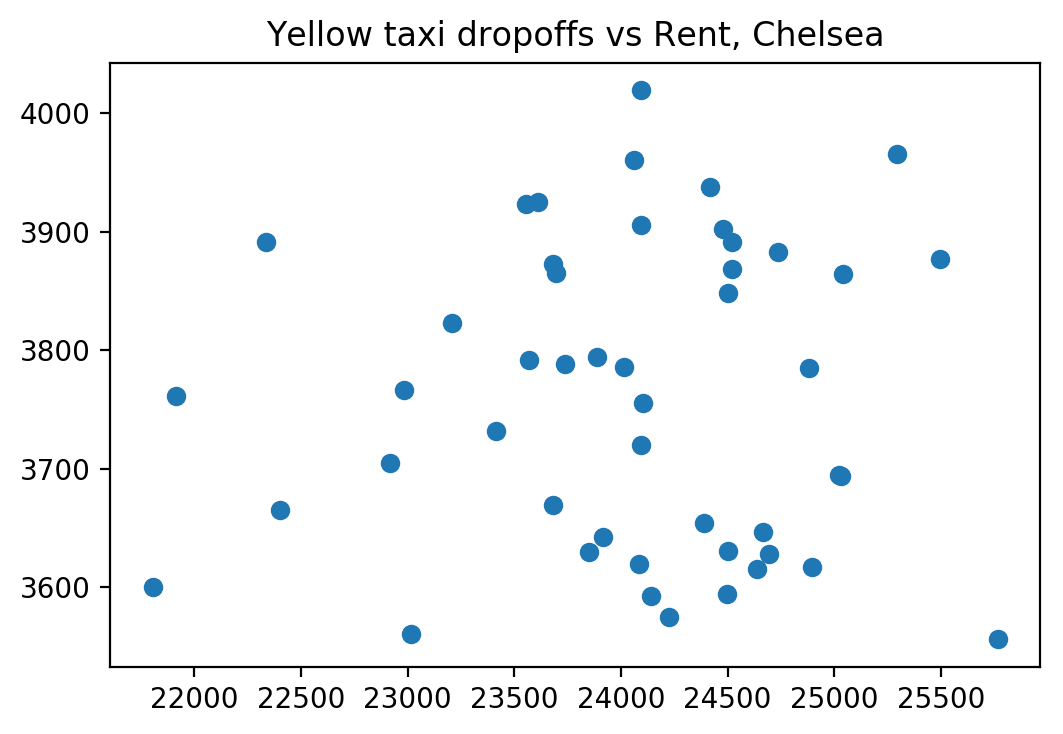

0.0372966172898
{u'zillow_ids': [276254], u'id': 135, u'name': u'Chelsea', u'taxi_ids': [68, 90, 246]}


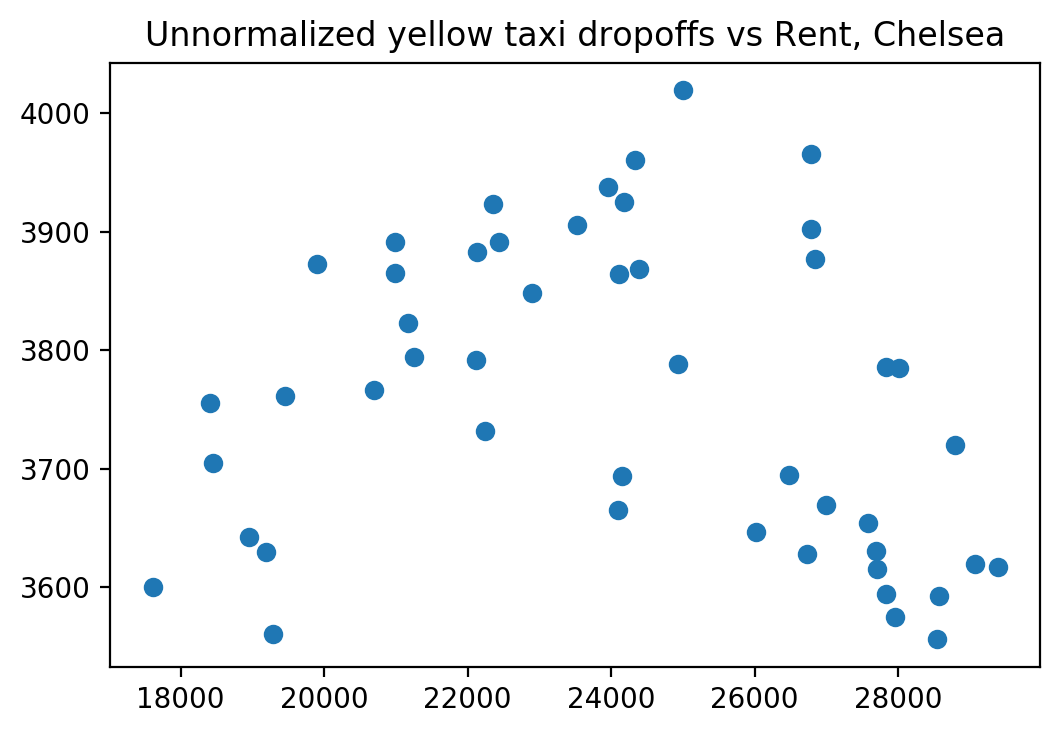

-0.197691399371


In [43]:
_ = single_location('Chelsea', zillow_composite, yellow,
                None,
                None,
                'Yellow taxi dropoffs vs Rent, Chelsea')

_ = single_location('Chelsea', zillow_composite, yellow_no_norm,
                None,
                None,
                'Unnormalized yellow taxi dropoffs vs Rent, Chelsea')

# Statistical Tests

Null hypothesis:
1. Taxi dropoffs at a certain location and rent aren't correlated.
1. Within each region, correlation should be random due to noise.
1. That means on average, half of the regions will have positive correlation, and half will have negative correlation, because we're just trying to find signal from random noise.
1. Rent-Taxi correlations between neighborhoods are independent of each other (admittedly a big assumption)

So if the null hypothesis holds, the direction of the correlations should be a fair coin flip ($p = 0.5$). We'll evaluate the correlation directions of each regions, and see if the result is likely under the null hypothesis.

In [57]:
from scipy.stats import norm

def evaluate(zillow_composite, yellow, title, metric='count', log=True):
    # What neighborhoods are available?
    avail_ids = set(zillow_composite[1].keys()).intersection(set(yellow[1].keys()))
    corr = {}
    for cid in avail_ids:
        # Get taxi data
        taxi = yellow[1][cid]
        zillow = zillow_composite[1][cid]
        join = pd.merge(taxi, zillow, on=['year', 'month'])
        join = join.set_index(['year', 'month'])
        corr_cid = join[metric].corr(join['price'])
        if cid >= 0:
            corr[cid] = corr_cid
    
    corrs = sorted(list(corr.iteritems()), key=lambda x: abs(x[1]), reverse=True)
    if log:
        for cid, c in corrs[:50]: # Top N most correlated/anticorrelated
            name = cid_to_cluster[cid]['name']
            print(name, c)

    corr = pd.Series(corr)

    if log:
        plt.figure()
        corr.hist(ax=plt.gca())
        plt.title(title)
        plt.ylabel('Num. of regions')
        plt.xlabel('Correlation')
        plt.axvline(x=0.0, color='red')
        plt.show()

    # Statistical test.
    n = len(corr)
    # 1 means "positive direction" and 0 means "negative direction".
    # Under H_0, the test statistic should be 0.5 * len(corr)
    t = sum(1 - np.signbit(corr.as_matrix())) # signbit -> positive -> False
    t = max(t, n - t) # Either positive or negative
    z = (t - n / 2.0) / np.sqrt(n * 0.5 * 0.5)

    # Normal approximation
    p = norm.sf(z) + norm.cdf(-z)

    if log:
        print('N:', n)
        print('t:', t)
        print('alph:', 1.96)
        print('z:', z)
        print('p:', p)
    
    return (n, t, z, p)

In [ ]:
metrics = ['count', 'distance', 'fare']
weekend = [None, True, False]

results = []
for m in metrics:
    for w in weekend:
        setting = 'metric={}, weekend={}'.format(m, w)
        taxis = get_taxis(add_green=False, metric=m, weekend_only=w)
        N, t, z, p = evaluate(zillow_composite, taxis, '', log=False)
        results.append((setting, N, t, z, p))
        print(setting, p)
        
results_pd = pd.DataFrame(results)
results_pd.columns = [
    'setting',
    'num_regions',
    'test_stat',
    'z_score',
    'p_value'
]

Erasmus-Flatbush/Ditmas Park 0.805239510647
Bronxdale-Co-Op City-Eastchester-Williamsbridge/Olinville 0.798211818823
Kingsbridge Heights-University Heights/Morris Heights 0.78095417269
Harlem 0.741081831089
Kew Gardens-Richmond Hill 0.735025374554
Parkchester 0.706888772759
Williamsburg 0.698700328063
East New York 0.6830752499
Concourse 0.677598876982
Bedford Park-Spuyten Duyvil/Kingsbridge-Van Cortlandt Village 0.671892523216
Pelham Parkway-Van Nest/Morris Park 0.665138282611
Norwood 0.646088542365
Mount Hope 0.642646702263
Greenwich Village-NoHo-West Village 0.639798245888
Elmhurst 0.638556169859
East Flatbush 0.634520047409
Flatlands-Midwood 0.612373649399
Jamaica 0.611229815455
Crown Heights 0.584849856512
Flushing-Murray Hill-Auburndale 0.58461536905
East Harlem 0.566273017292
Washington Heights 0.494162835218
Boerum Hill-Carroll Gardens-Gowanus 0.481406774136
Pelham Bay-Schuylerville/Edgewater Park 0.455204597857
Windsor Terrace 0.444688550107
Clinton Hill-Bedford Stuyvesant 0.4

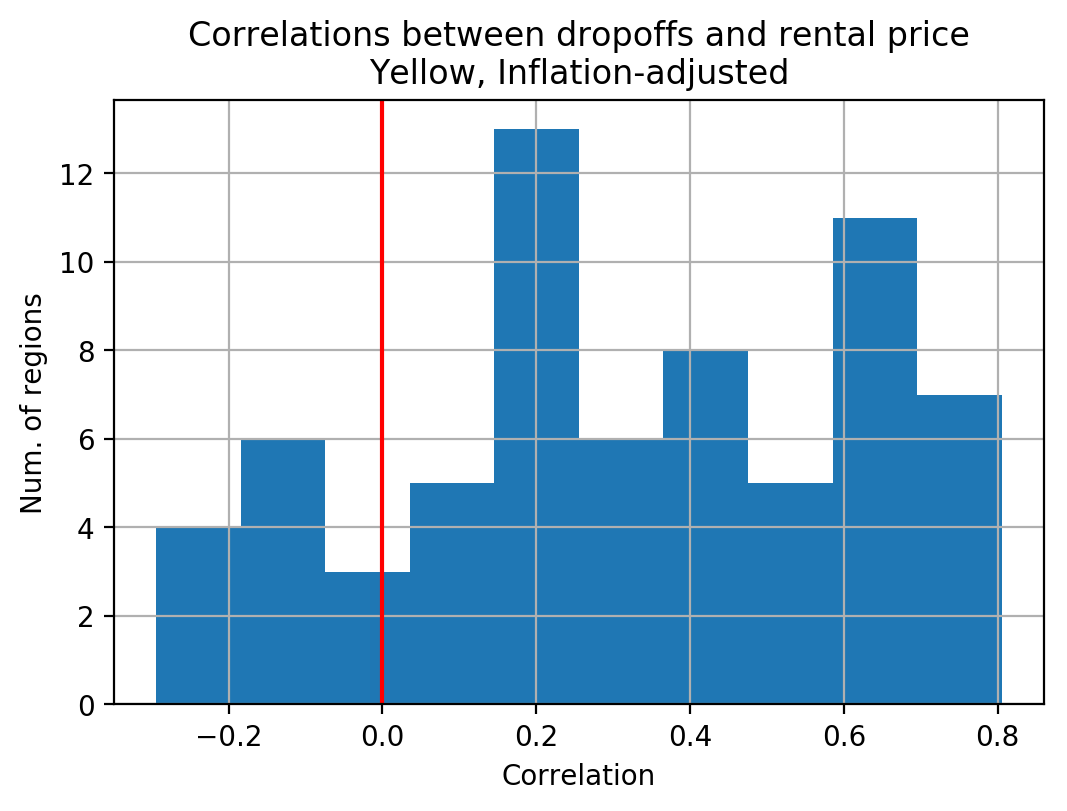

N: 68
t: 55
alph: 1.96
z: 5.09324812576
p: 3.51980560064e-07


In [391]:
evaluate(zillow_composite, yellow,
        'Correlations between dropoffs and rental price\n'
              'Yellow, Inflation-adjusted')

Harlem 0.870139100867
Erasmus-Flatbush/Ditmas Park 0.817518048275
Washington Heights 0.802823689951
Kingsbridge Heights-University Heights/Morris Heights 0.797812168287
Bronxdale-Co-Op City-Eastchester-Williamsbridge/Olinville 0.791687708735
Hamilton Heights-Manhattanville 0.781648077952
East New York 0.761828934961
Bedford Park-Spuyten Duyvil/Kingsbridge-Van Cortlandt Village 0.761189648481
Elmhurst 0.748825216684
East Flatbush 0.744292899966
East Harlem 0.731064806762
Parkchester 0.729292548608
Concourse 0.723597821617
Kew Gardens-Richmond Hill 0.705888637849
Pelham Parkway-Van Nest/Morris Park 0.703867071591
Mount Hope 0.700241947075
Jamaica 0.699633356679
Norwood 0.693772632441
Battery Park City 0.639758514806
Flatlands-Midwood 0.62651734529
Inwood 0.612486914292
Crown Heights 0.594501198291
Soundview/Bruckner-Soundview/Castle Hill-West Farms/Bronx River-Westchester Village/Unionport 0.574386043098
Flushing-Murray Hill-Auburndale 0.540656618995
Pelham Bay-Schuylerville/Edgewater Pa

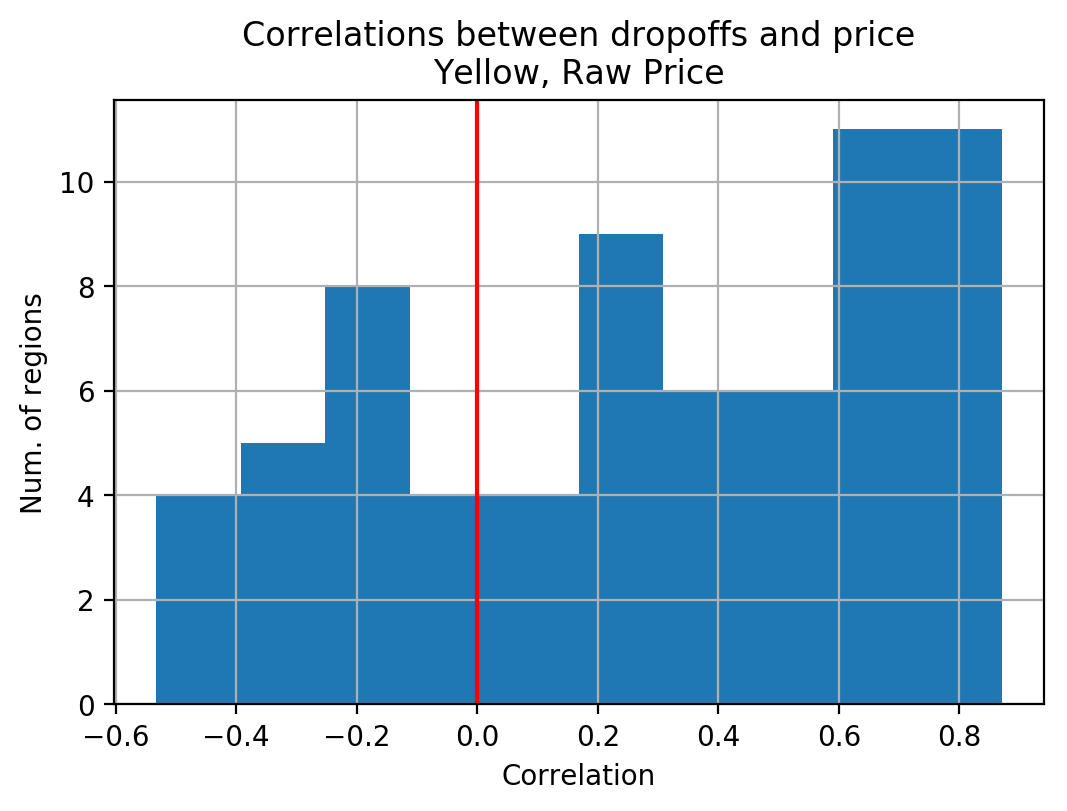

N: 68
t: 48
alph: 1.96
z: 3.39549875051
p: 0.000685036865379


In [392]:
evaluate(zillow_no_inflation, yellow,
        'Correlations between dropoffs and price\n'
              'Yellow, Raw Price')

Erasmus-Flatbush/Ditmas Park 0.805239510647
Bronxdale-Co-Op City-Eastchester-Williamsbridge/Olinville 0.798211818823
Kingsbridge Heights-University Heights/Morris Heights 0.78095417269
Harlem 0.741081831089
Kew Gardens-Richmond Hill 0.735025374554
Parkchester 0.706888772759
Williamsburg 0.698700328063
East New York 0.6830752499
Concourse 0.677598876982
Bedford Park-Spuyten Duyvil/Kingsbridge-Van Cortlandt Village 0.671892523216
Pelham Parkway-Van Nest/Morris Park 0.665138282611
Norwood 0.646088542365
Mount Hope 0.642646702263
Elmhurst 0.638556169859
East Flatbush 0.634520047409
Flatlands-Midwood 0.612373649399
Jamaica 0.611229815455
Crown Heights 0.584849856512
Flushing-Murray Hill-Auburndale 0.58461536905
Washington Heights 0.494162835218
Boerum Hill-Carroll Gardens-Gowanus 0.481406774136
Pelham Bay-Schuylerville/Edgewater Park 0.455204597857
Windsor Terrace 0.444688550107
Clinton Hill-Bedford Stuyvesant 0.441941963145
Forest Hills-Forest Park/Highland Park-Glendale 0.43850249166
Batt

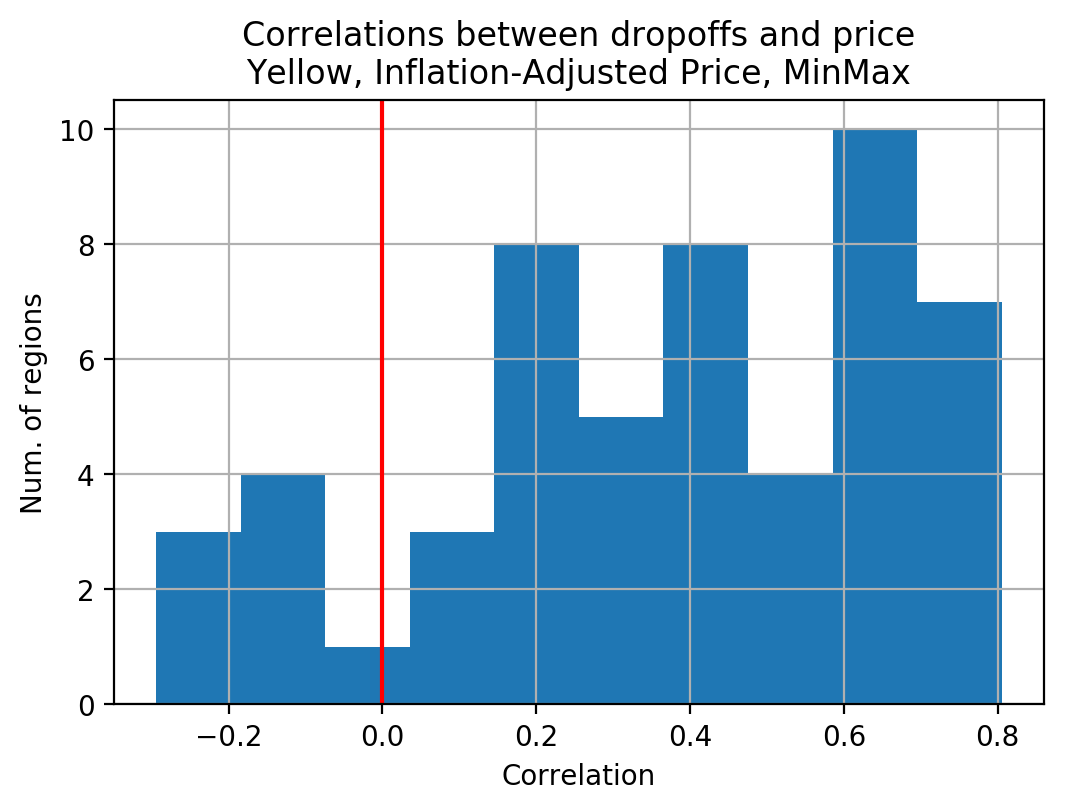

N: 53
t: 45
alph: 1.96
z: 5.0823408661
p: 3.72811611586e-07


In [393]:
evaluate(zillow_composite, yellow_min_max,
        'Correlations between dropoffs and price\n'
              'Yellow, Inflation-Adjusted Price, MinMax')